In [1]:
import sys
from itertools import groupby
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils

import torchvision.transforms.functional as TF
from torchvision import datasets, transforms

## EMNIST Dataset

In [2]:
emnist_dataset = datasets.EMNIST('./EMNIST', split="digits", train=True, download=True)

100%|██████████| 561753746/561753746 [00:16<00:00, 35104206.09it/s]


Extracting ./EMNIST/EMNIST/raw/gzip.zip to ./EMNIST/EMNIST/raw


### Create Sequences

In [3]:
number_of_sequences = 10000
blank_label = 10

In [4]:
min_seq_len, max_seq_len = 5, 10

In [5]:
dataset_sequences = []
dataset_labels = []

for i in range(number_of_sequences):
    digits_per_sequence = np.random.randint(min_seq_len, max_seq_len) # random
    random_indices = np.random.randint(len(emnist_dataset.data), size=(digits_per_sequence,))
    random_digits_images = emnist_dataset.data[random_indices]
    transformed_random_digits_images = []

    for img in random_digits_images:
        img = transforms.ToPILImage()(img)
        img = TF.rotate(img, -90, fill=0) # rotate -90 degree
        img = TF.hflip(img) # horizontally flip
        img = transforms.RandomAffine(degrees=10, translate=(0.2, 0.15), scale=(0.8, 1.1))(img) # random tranformation
        img = transforms.ToTensor()(img).numpy()
        transformed_random_digits_images.append(img)

    random_digits_images = np.array(transformed_random_digits_images)
    random_digits_labels = emnist_dataset.targets[random_indices]

    blank_image = np.zeros((28, 28))

    if digits_per_sequence < 10:
        # Pad images with blank images
        padding_length = 10 - digits_per_sequence
        padded_images = np.array([[blank_image]] * padding_length)
        random_digits_images = np.vstack((random_digits_images, padded_images))  # Stack blank images

        # Pad labels with 10
        padded_labels = np.array([blank_label] * padding_length)
        random_digits_labels = np.hstack((random_digits_labels, padded_labels))  # Stack placeholder labels

    assert random_digits_images.shape[0] == 10
    assert random_digits_labels.shape[0] == 10

    random_sequence = np.hstack(random_digits_images.reshape(10, 28, 28))

    dataset_sequences.append(random_sequence / 255)  # Normalize the sequence
    dataset_labels.append(random_digits_labels)

In [6]:
len(dataset_sequences), len(dataset_labels)

(10000, 10000)

In [7]:
dataset_data = torch.Tensor(np.array(dataset_sequences))
dataset_labels = torch.IntTensor(np.array(dataset_labels))

In [9]:
dataset_labels[:5]

tensor([[ 0,  7,  4,  7,  7,  9, 10, 10, 10, 10],
        [ 0,  3,  1,  9,  1,  1, 10, 10, 10, 10],
        [ 4,  5,  4,  0,  0,  1,  2,  6, 10, 10],
        [ 2,  8,  7,  6,  7,  5,  6,  2, 10, 10],
        [ 5,  4,  0,  9,  1,  7,  9, 10, 10, 10]], dtype=torch.int32)

In [10]:
seq_dataset = data_utils.TensorDataset(dataset_data, dataset_labels)
train_set, val_set = torch.utils.data.random_split(
    dataset=seq_dataset,
    lengths=[int(len(seq_dataset) * 0.8), int(len(seq_dataset) * 0.2)]
)

## Train/Validation Dataloaders

In [11]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=True)

## CRNN

In [12]:
num_classes = 11
gru_hidden_size = 128
gru_num_layers = 2
cnn_output_height = 4
cnn_output_width = 32

In [17]:
class CRNN(nn.Module):
    def __init__(self):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3))
        self.norm1 = nn.InstanceNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2)
        self.norm2 = nn.InstanceNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.norm3 = nn.InstanceNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=2)
        self.norm4 = nn.InstanceNorm2d(64)
        self.gru_input_size = cnn_output_height * 64
        self.gru = nn.GRU(
            self.gru_input_size, gru_hidden_size, gru_num_layers, batch_first=True, bidirectional=True
        )
        self.fc = nn.Linear(gru_hidden_size * 2, num_classes)

    def forward(self, x): # (1, 28, 280)
        batch_size = x.shape[0]
        out = self.conv1(x) # (32, 26, 278)
        out = self.norm1(out)
        out = F.leaky_relu(out)

        out = self.conv2(out) # (32, 12, 138)
        out = self.norm2(out)
        out = F.leaky_relu(out)

        out = self.conv3(out) # (64, 10, 136)
        out = self.norm3(out)
        out = F.leaky_relu(out)

        out = self.conv4(out) # (64, 4, 67)
        out = self.norm4(out)
        out = F.leaky_relu(out)

        out = out.permute(0, 3, 2, 1)
        out = out.reshape(batch_size, -1, self.gru_input_size)
        out, _ = self.gru(out)
        out = torch.stack([F.log_softmax(self.fc(out[i]), dim=-1) for i in range(out.shape[0])])
        return out

In [18]:
print(CRNN())

CRNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (norm1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
  (norm2): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (norm3): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
  (norm4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (gru): GRU(256, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=11, bias=True)
)


## Digit Wise Accuracy

$P = [p_1, p_2, \dots, p_{n_p}]$ - predicted digits with length $n_p$.

$G = [g_1, g_2, \dots, g_{n_g}]$ - ground truth digits with length $n_g$.

---
**Remove blank labels from ground truth sequence:**

$$
G' = [g'_1, g'_2, \dots, g'_{n_{g'}}] \quad \text{where} \quad g'_i \neq B
$$

---
If $n_p$ <  $n_{g'}$: -> (padding with blank labels)

$else$: -> (truncate with ground truth digit sequence length $n_{g'}$)

---
**Correct Digits:**

$$
\text{correct_digits} = \sum_{i=1}^{n_{g'}} \mathbb{1}(p'_i' = g'_i)
$$

---
**Accuracy:**

$$
   \text{accuracy} = \frac{\text{correct_digits}}{n_{g'}}
$$

In [19]:
def digit_wise_acc(prediction, ground_truth, blank_label: int = 10) -> float:
    ground_truth = ground_truth[ground_truth != blank_label]
    pred_len, gt_len = len(prediction), len(ground_truth)
    if pred_len < gt_len:
        padding = torch.full((gt_len - pred_len,), blank_label, dtype=torch.int)
        prediction = torch.cat((prediction, padding))

    digits_sequence_len = len(ground_truth)

    if len(prediction) > 0:
        correct_digits = torch.sum(
            prediction[:digits_sequence_len].eq(ground_truth[:digits_sequence_len])
        ).item()
        return correct_digits / digits_sequence_len
    return 0.0

## Train

In [26]:
epochs = 20
cuda = torch.cuda.is_available()

model = CRNN()

if cuda:
    model = CRNN().cuda()

criterion = nn.CTCLoss(blank=blank_label, reduction='mean', zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [27]:
(x_test, y_test) = next(iter(val_loader))
x_test.size()

torch.Size([64, 28, 280])

In [28]:
acc = []
for _ in range(epochs):
    epoch_acc = []
    for x_train, y_train in tqdm(
        train_loader, position=0, leave=True, file=sys.stdout
    ):
        batch_size = x_train.shape[0]  # x_train.shape == torch.Size([64, 28, 140])
        x_train = x_train.view(
            x_train.shape[0], 1, x_train.shape[1], x_train.shape[2]
        )
        optimizer.zero_grad()
        if cuda:
            x_train = x_train.cuda()

        y_pred = model(x_train.cuda())
        y_pred = y_pred.permute(1, 0, 2)  # y_pred.shape == torch.Size([64, 32, 11])
        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
        target_lengths = torch.IntTensor([len(t) for t in y_train])

        loss = criterion(y_pred, y_train, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()

        batch_acc = []
        _, max_index = torch.max(y_pred, dim=2)  # max_index.shape == torch.Size([32, 64])
        for i in range(batch_size):
            digit_correct = 0
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())  # len(raw_prediction) == 32
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])

            batch_acc.append(digit_wise_acc(prediction, y_train[i]))

        epoch_acc.append(sum(batch_acc) / batch_size)

    mean_epoch_acc = sum(epoch_acc) / len(epoch_acc) if epoch_acc else 0
    acc.append(mean_epoch_acc)
    print('TRAINING.', 'Accuracy:',  mean_epoch_acc)


100%|██████████| 125/125 [00:07<00:00, 17.42it/s]
TRAINING. Accuracy: 0.024134325396825394
100%|██████████| 125/125 [00:06<00:00, 18.51it/s]
TRAINING. Accuracy: 0.05742291666666665
100%|██████████| 125/125 [00:06<00:00, 19.44it/s]
TRAINING. Accuracy: 0.12842569444444443
100%|██████████| 125/125 [00:06<00:00, 18.58it/s]
TRAINING. Accuracy: 0.23867698412698413
100%|██████████| 125/125 [00:06<00:00, 19.28it/s]
TRAINING. Accuracy: 0.3342671130952379
100%|██████████| 125/125 [00:07<00:00, 17.83it/s]
TRAINING. Accuracy: 0.4318053075396825
100%|██████████| 125/125 [00:06<00:00, 17.95it/s]
TRAINING. Accuracy: 0.5164881448412697
100%|██████████| 125/125 [00:06<00:00, 19.95it/s]
TRAINING. Accuracy: 0.5842832837301585
100%|██████████| 125/125 [00:06<00:00, 18.85it/s]
TRAINING. Accuracy: 0.6382566964285713
100%|██████████| 125/125 [00:06<00:00, 20.26it/s]
TRAINING. Accuracy: 0.6896895337301587
100%|██████████| 125/125 [00:06<00:00, 18.81it/s]
TRAINING. Accuracy: 0.7769083333333325
100%|██████████|

## Test

In [29]:
def test_model(model, test_loader, blank_label: int = 10):
    model.eval()
    test_preds = []
    acc = []

    (x_test, y_test) = next(iter(test_loader))
    y_pred = model(x_test.view(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2]).cuda())
    y_pred = y_pred.permute(1, 0, 2)

    _, max_index = torch.max(y_pred, dim=2)

    for i in range(x_test.shape[0]):
        raw_prediction = list(max_index[:, i].detach().cpu().numpy())
        prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
        ground_truth_filtered = y_test[i][y_test[i] != blank_label]
        acc.append(digit_wise_acc(prediction, ground_truth_filtered))
        test_preds.append(prediction)

        plt.figure(figsize=(6, 3))
        plt.imshow(x_test[i].cpu().numpy(), cmap='gray')
        plt.title(f"Actual: {ground_truth_filtered.numpy()} | Predicted: {test_preds[i].numpy()} | Acc: {acc[i]:.2f}")
        plt.axis('off')
        plt.show()

    return test_preds, acc

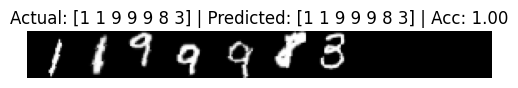

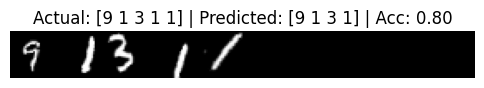

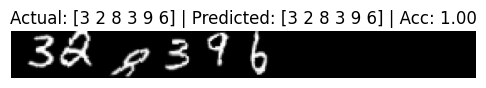

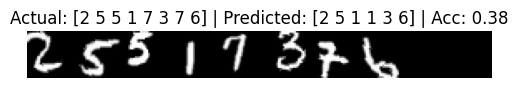

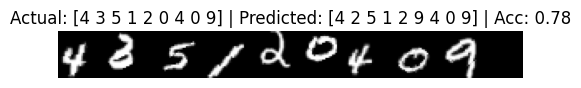

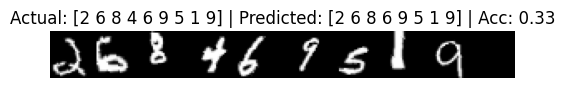

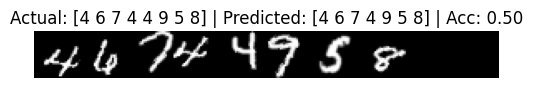

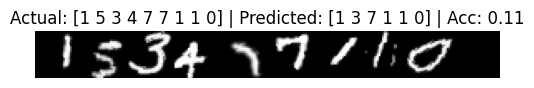

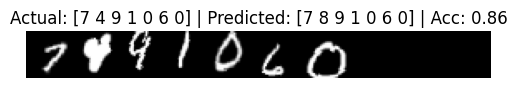

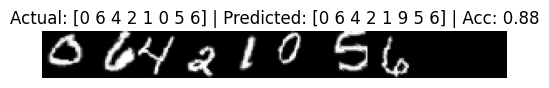

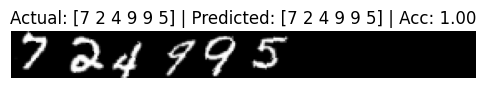

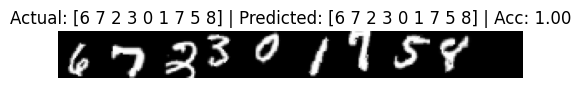

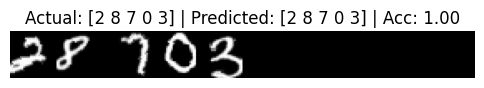

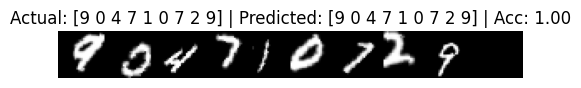

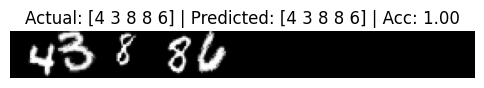

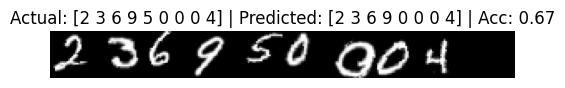

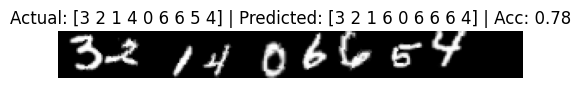

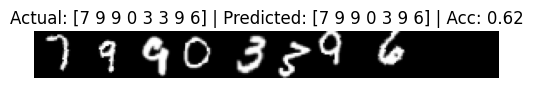

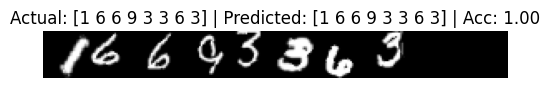

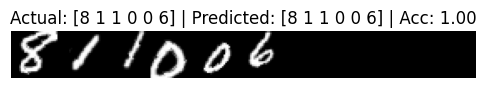

In [30]:
number_of_test_imgs = 20
test_loader = torch.utils.data.DataLoader(val_set, batch_size=number_of_test_imgs, shuffle=True)
test_preds, acc = test_model(model, test_loader, 10)